<a href="https://colab.research.google.com/github/benmanjackson/CS290/blob/main/Mystery_Kmeans_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 12/21/24 Homework

## Task



* Test our K-means clustering algorithm on a mystery dataset and find k.


[Dataset](https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv).


## Load and inspect the data

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.ticker import FixedLocator, FixedFormatter
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import silhouette_score, silhouette_samples, confusion_matrix

In [ ]:
df = pd.read_csv("https://github.com/mbrudd/csci290/raw/refs/heads/main/data/mystery.csv")

In [ ]:
df.head()

,feature_ 1,feature_ 2,feature_ 3,feature_ 4,feature_ 5,feature_ 6,feature_ 7,feature_ 8,feature_ 9,feature_10,...,feature_13,feature_14,feature_15,feature_16,feature_17,feature_18,feature_19,feature_20,feature_21,feature_22
0,1.0,0.152936,-0.105586,0.200722,0.317201,0.260764,0.100945,-0.150063,-0.171128,0.124676,...,-0.156436,0.082245,0.135752,-0.024017,-0.108351,-0.077623,-0.009568,0.057684,0.118680,0.014038
1,1.0,0.171534,-0.098975,0.268425,0.338672,0.268353,0.060835,-0.222475,-0.207693,0.170883,...,-0.254341,0.022786,0.163320,0.012022,-0.090974,-0.056510,-0.035303,0.020140,0.082263,0.029056
2,1.0,0.152317,-0.082973,0.287128,0.276014,0.189867,0.008714,-0.242234,-0.219153,0.232538,...,-0.237384,0.050791,0.207338,0.083536,-0.050691,-0.023590,-0.066722,-0.025083,0.099108,0.077162
3,1.0,0.224392,0.118985,0.329432,0.372088,0.361005,0.015501,-0.194347,-0.098181,0.270375,...,-0.317084,-0.011567,0.100413,-0.050224,-0.136009,-0.177037,-0.130498,-0.054766,-0.018691,0.023954
4,1.0,0.087817,-0.068345,0.306967,0.330923,0.249144,0.006884,-0.265423,-0.172700,0.266434,...,-0.298524,0.037439,0.219153,0.062837,-0.048885,-0.053074,-0.088550,-0.031346,0.108610,0.079244


In [ ]:
print(df.columns)
print(df.info())

Index(['feature_ 1', 'feature_ 2', 'feature_ 3', 'feature_ 4', 'feature_ 5',
       'feature_ 6', 'feature_ 7', 'feature_ 8', 'feature_ 9', 'feature_10',
       'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15',
       'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20',
       'feature_21', 'feature_22'],
      dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7195 entries, 0 to 7194
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   feature_ 1  7195 non-null   float64
 1   feature_ 2  7195 non-null   float64
 2   feature_ 3  7195 non-null   float64
 3   feature_ 4  7195 non-null   float64
 4   feature_ 5  7195 non-null   float64
 5   feature_ 6  7195 non-null   float64
 6   feature_ 7  7195 non-null   float64
 7   feature_ 8  7195 non-null   float64
 8   feature_ 9  7195 non-null   float64
 9   feature_10  7195 non-null   float64
 10  feature_11  7195 non-null   fl

In [ ]:
#Only num features:
numerical_features = df.select_dtypes(include=['int64', 'float64']).columns
print("Numerical Features:", list(numerical_features))
X = df[numerical_features].to_numpy()

Numerical Features: ['feature_ 1', 'feature_ 2', 'feature_ 3', 'feature_ 4', 'feature_ 5', 'feature_ 6', 'feature_ 7', 'feature_ 8', 'feature_ 9', 'feature_10', 'feature_11', 'feature_12', 'feature_13', 'feature_14', 'feature_15', 'feature_16', 'feature_17', 'feature_18', 'feature_19', 'feature_20', 'feature_21', 'feature_22']


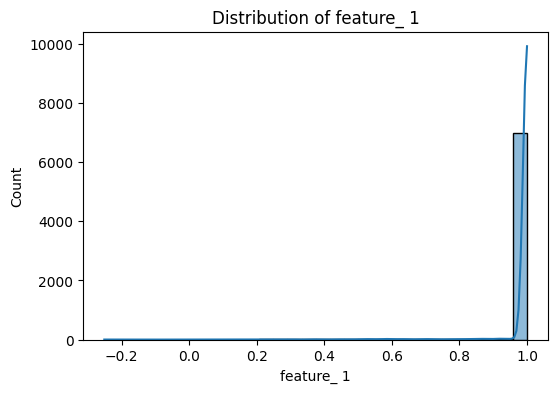

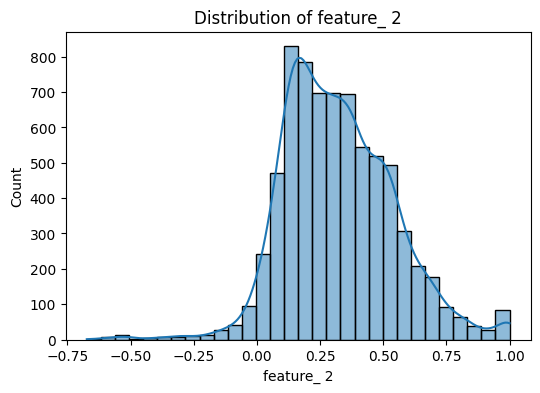

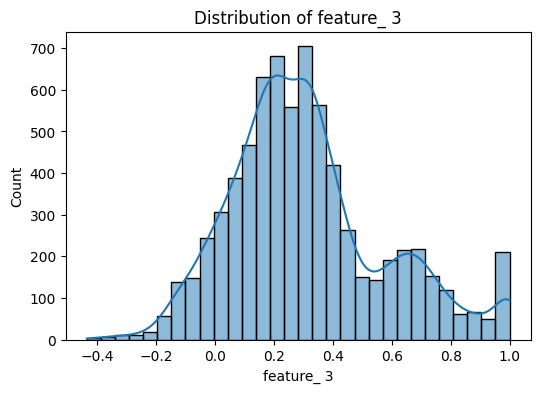

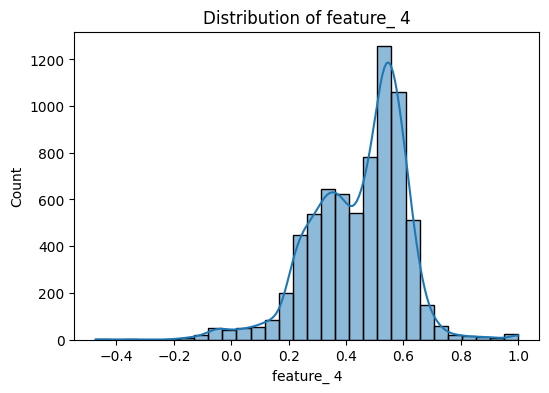

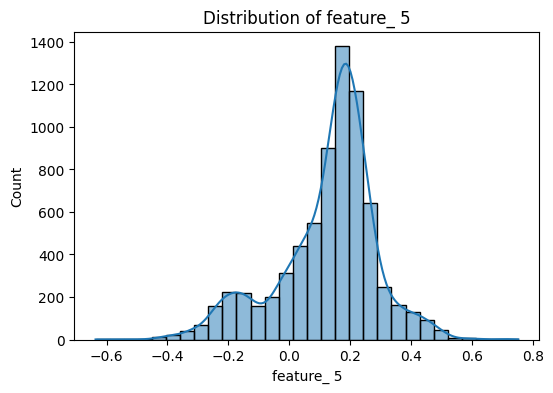

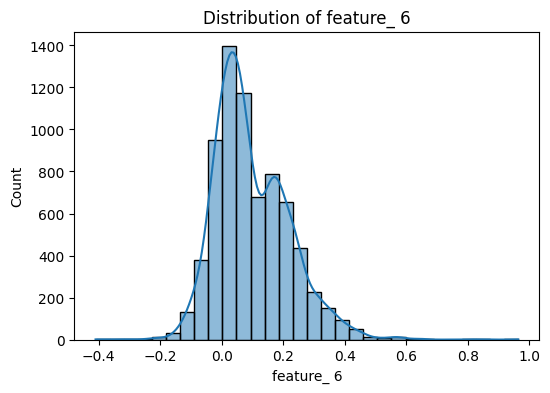

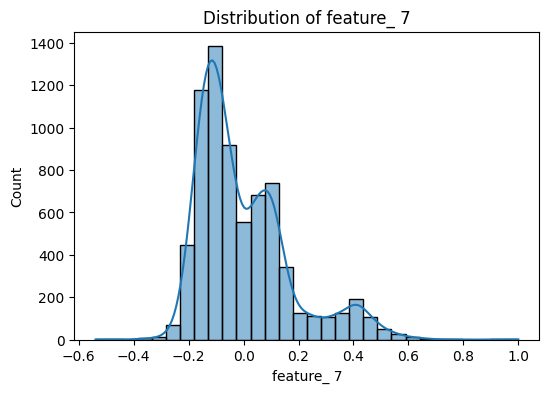

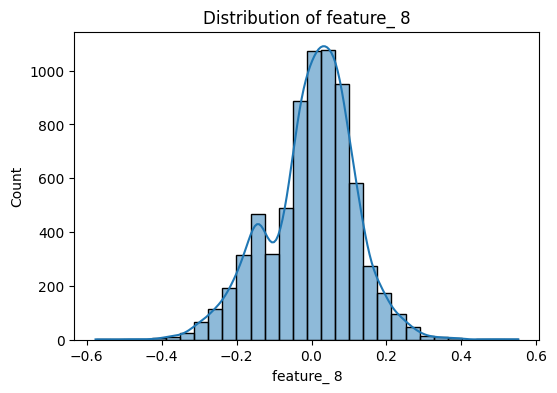

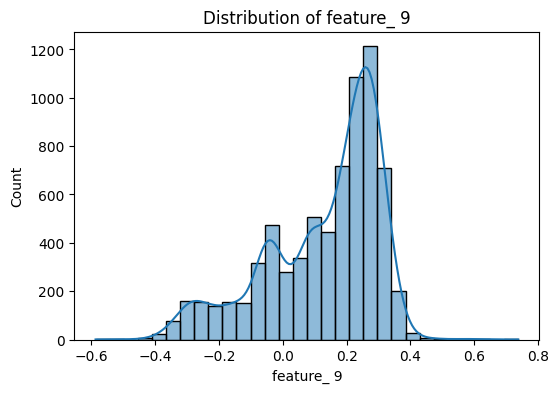

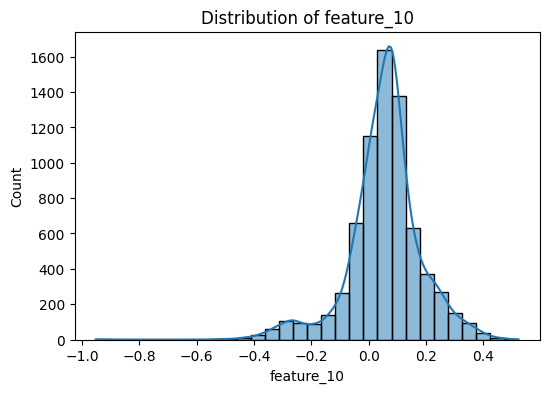

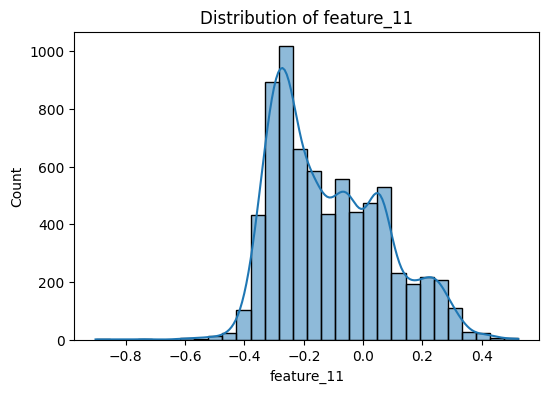

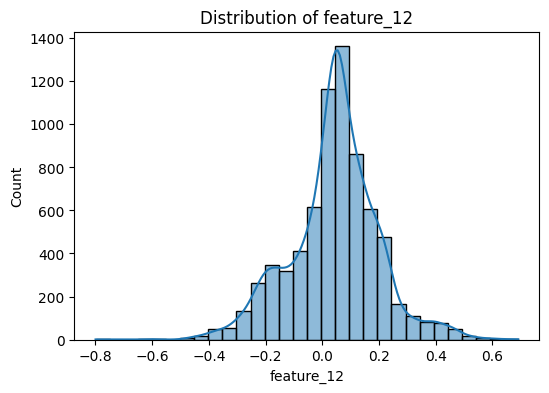

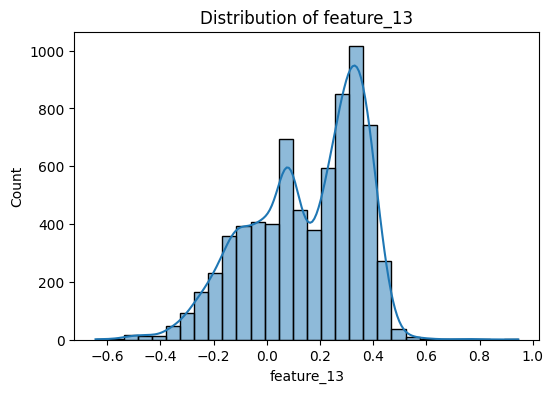

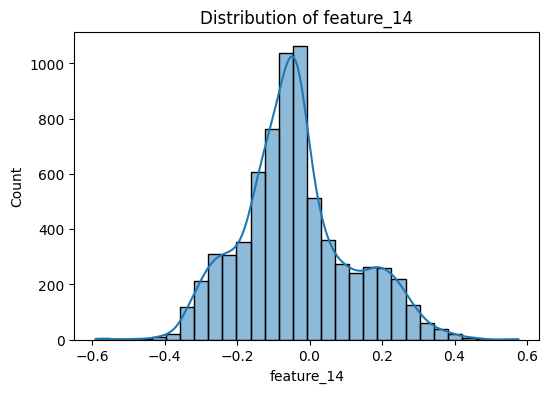

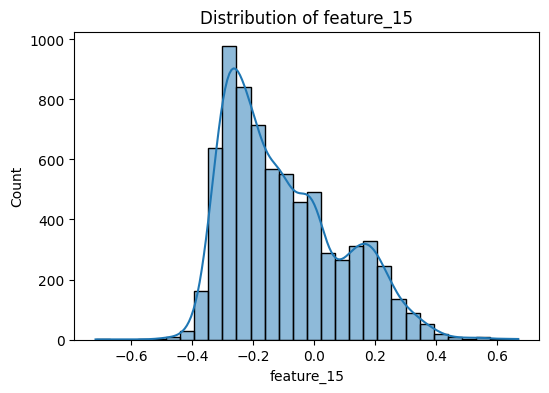

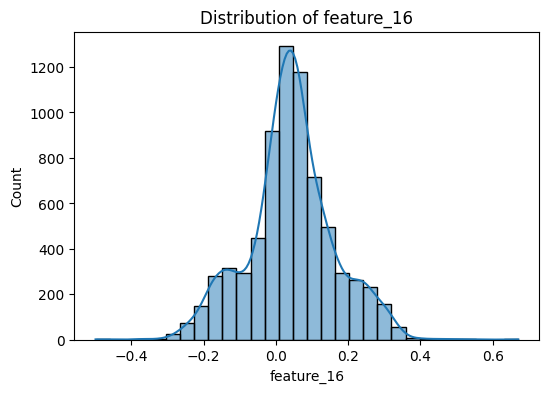

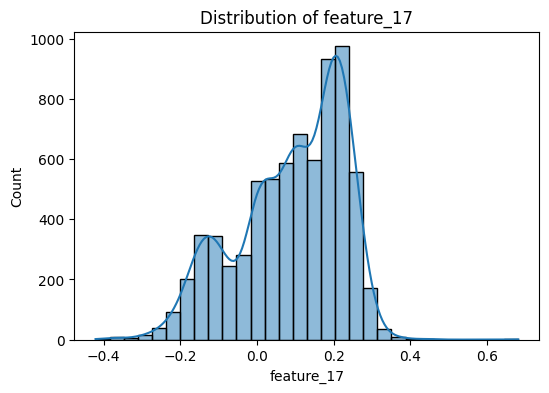

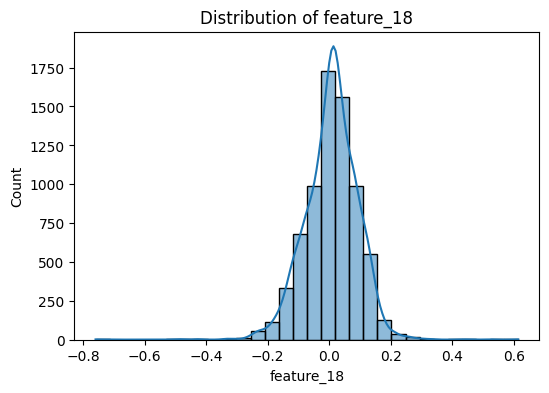

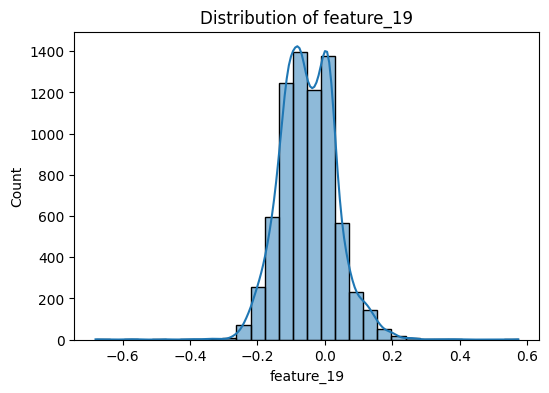

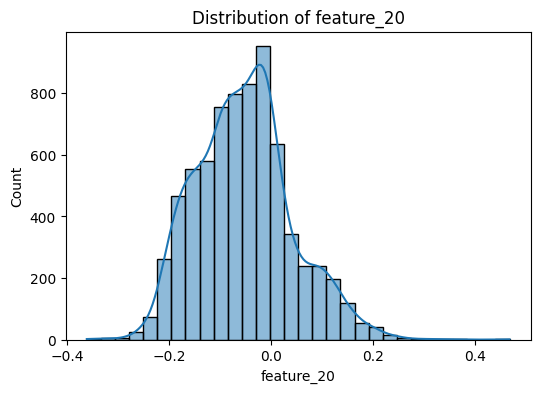

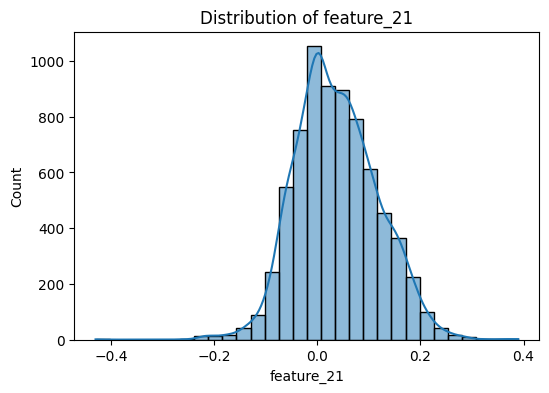

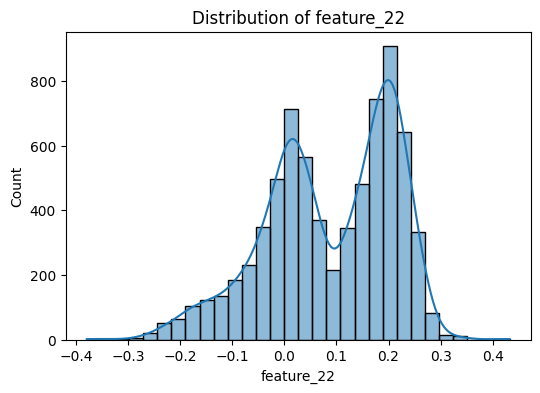

In [ ]:
#Distribution of each numerical feature
for col in numerical_features:
    plt.figure(figsize=(6, 4))
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribution of {col}")
    plt.show()

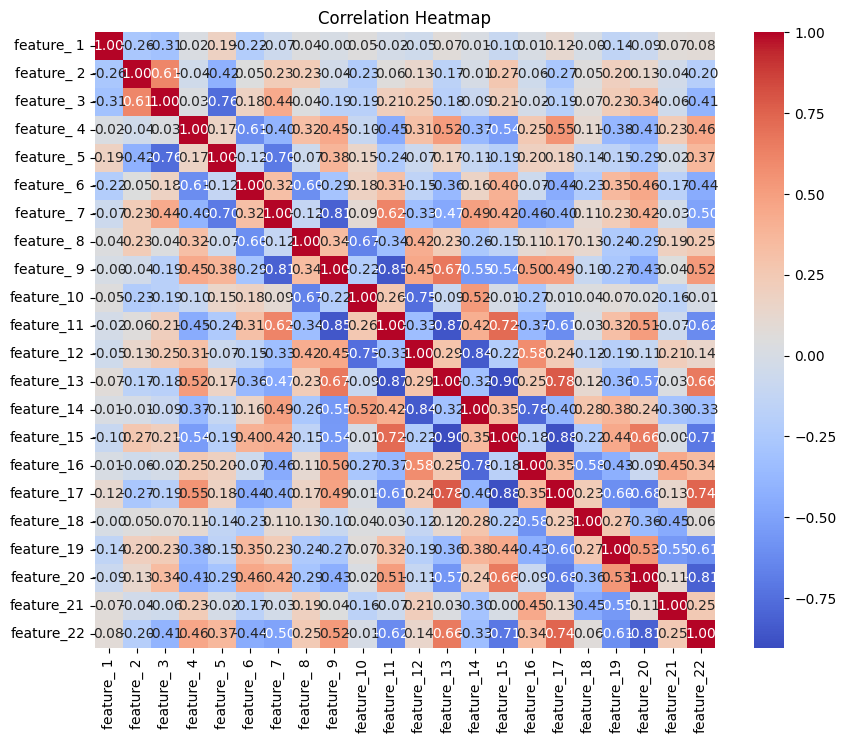

In [ ]:
#Correlation Heatmap of features
plt.figure(figsize=(10, 8))
sns.heatmap(df[numerical_features].corr(), annot=True, fmt=".2f", cmap="coolwarm")
plt.title("Correlation Heatmap")
plt.show()

# Get Imports, manage DataFrame and create our functions

In [ ]:
#Scale numerical data for our k-means alg
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print(f"Processed Dataset Shape: {X_scaled.shape}")

Processed Dataset Shape: (7195, 22)


In [ ]:
#fill nan with avg of each column
df[numerical_features] = df[numerical_features].fillna(df[numerical_features].mean())

In [ ]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

In [ ]:
# This is our inertia function, the sum of squared distances of samples to their closest cluster center
def calculate_inertia(X, centroids, clusters):
    distances = np.array([np.array([euclidean_distance(x, centroid) for x in X]) for centroid in centroids])
    return np.sum(np.min(distances, axis=0))

In [ ]:
# Accuracy (if true labels are available)
def calculate_accuracy(true_labels, predicted_labels):
    cm = confusion_matrix(true_labels, predicted_labels)
    return np.sum(np.amax(cm, axis=0)) / np.sum(cm)

In [ ]:
#This function is used to initialize our centroids for k-means clustering
def initialize_centroids(X, k, method="random"):
    if method == "random":
      #This will randomly select k datapoints for our initial centroids
        indices = np.random.choice(X.shape[0], size=k, replace=False)
        return X[indices]
    elif method == "kmeans++":
      #K-means++ initialization as described by Arthur and Vassilvitskii
        centroids = [X[np.random.randint(X.shape[0])]] #begins with a random centroid
        for _ in range(1, k):
          #Computes euclidean distance of each point with closest centroid
            distances = np.array([np.min([euclidean_distance(x, centroid) for centroid in centroids]) for x in X])
            #This is the probability proportional to the distance squared
            probs = distances**2 / np.sum(distances**2)
            new_centroid = X[np.random.choice(range(X.shape[0]), p=probs)]
            centroids.append(new_centroid)
        return np.array(centroids)
    else:
        raise ValueError("Invalid method specified for centroid initialization. Maybe try 'random' or 'k-means++'.")

In [ ]:
#This function will assign each data point with their nearest centroid.
def assign_clusters(X, centroids):
  #computes distances from each point to each centroid
    distances = np.array([[euclidean_distance(x, centroid) for centroid in centroids] for x in X])
    #Returns index of closest centroid for each point
    return np.argmin(distances, axis=1)

In [ ]:
#This will be our updating centroids function, which updates centroids via the mean of the points in each cluster
#NEEDS WORK
def update_centroids(X, clusters, k):
    new_centroids = np.zeros((k, X.shape[1]))  # Initialize centroids with zeros
    for j in range(k):
        #Select the points that belong to cluster j
        cluster_points = X[clusters == j]

        #DEBUGGING: Check the shape of cluster_points and clusters
        print(f"Cluster {j}: Number of points = {len(cluster_points)}")
        print(f"Shape of cluster_points: {cluster_points.shape}")
        print(f"Shape of clusters array: {clusters.shape}")

        #If a cluster has no points assigned, lets pick a random point as the centroid
        if cluster_points.shape[0] > 0:
            new_centroids[j] = cluster_points.mean(axis=0)  #Mean across rows
        else:
            #If no points are assigned, just pick the old centroid
            new_centroids[j] = X[np.random.choice(X.shape[0])]

    return new_centroids

In [ ]:
#This function will plot our clusters, allowing us to visualize the current state of the data
def plot_clusters(X, clusters, centroids, iteration):
  plt.figure(figsize=(10, 6))
  for i in range(len(centroids)):
    #Plot the points in each cluster
    plt.scatter(X[clusters == i, 0], X[clusters == i, 1], label=f"Cluster {i+1}")
  #Now plot the centroids
  plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label="Centroids")
  plt.title(f"Iteration {iteration}")
  plt.legend()
  plt.show()

In [ ]:
def plot_elbow_graph(inertia_values):
    plt.figure(figsize=(8, 6))
    plt.plot(k_values, inertia_values, 'o-', color='blue', label="Inertia")
    plt.xlabel('Number of cluster (k)')
    plt.ylabel('Inertia')
    plt.title('Elbow Graph ')
    plt.grid(alpha=0.5)
    plt.legend()
    plt.show()

In [ ]:
#Based off code from 09_Unsupervised_Learning
def plot_silhouette_diagrams(X, kmeans_results, k_values):
    plt.figure(figsize=(15, 12))

    for idx, k in enumerate(k_values, start=1):
        plt.subplot(3, 3, idx)  # Adjust based on the number of k-values
        y_pred = kmeans_results[k].labels_
        silhouette_coefficients = silhouette_samples(X, y_pred)

        # Initialize variables for plotting
        padding = len(X) // 30
        pos = padding
        ticks = []

        for i in range(k):
            coeffs = silhouette_coefficients[y_pred == i]
            coeffs.sort()

            color = mpl.cm.Spectral(i / k)
            plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                              facecolor=color, edgecolor=color, alpha=0.7)
            ticks.append(pos + len(coeffs) // 2)
            pos += len(coeffs) + padding

        # Adjust y-axis ticks and labels
        plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
        plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))
        plt.ylabel("Cluster")
        plt.xlabel("Silhouette Coefficient")

        # Mark average silhouette score with a red dashed line
        silhouette_avg = silhouette_score(X, y_pred)
        plt.axvline(x=silhouette_avg, color="red", linestyle="--")
        plt.title("$k={}$".format(k), fontsize=14)

    plt.tight_layout()
    plt.show()

In [ ]:
#Finally, our k-means algorithm, which will perform k-means clustering, given input data
def k_means(X, k, max_iterations=100, tolerance=1e-4, init_method="random", true_labels=None):
  # Initialize the centroids first
    centroids = initialize_centroids(X, k, method=init_method)
    inertia_values = []  # Array for storing inertia for elbow graph

    for i in range(max_iterations):
        # Assign clusters to nearest centroid
        clusters = assign_clusters(X, centroids)

        # Next, update centroids as the mean of the assigned points
        new_centroids = update_centroids(X, clusters, k)

        # Calculate the inertia (sum of squared distances to the nearest centroid)
        inertia = calculate_inertia(X, centroids, clusters)
        inertia_values.append(inertia)

        # Calculate silhouette coefficient (if clusters are valid)
        silhouette = silhouette_score(X, clusters) if len(set(clusters)) > 1 else float('nan')

        # Print metrics for each iteration
        print(f"Iteration {i}:")
        print(f"  Inertia: {inertia:.4f}")
        print(f"  Silhouette Coefficient: {silhouette:.4f}")

        # Calculate accuracy if true labels are provided
        if true_labels is not None:
            accuracy = calculate_accuracy(true_labels, clusters)
            print(f"  Accuracy: {accuracy:.4f}")

        # Plot the progress of clustering
        plot_clusters(X, clusters, centroids, iteration=i)

        # Finally, check for convergence, where centroids don't move significantly
        diff = np.linalg.norm(centroids - new_centroids)
        print(f"Iteration {i}: Centroid shift = {diff:.4f}")
        if diff < tolerance:
            print(f"Convergence reached.")
            break

        # Update centroids for the next iteration
        centroids = new_centroids

    # Plot the elbow graph to visualize inertia over iterations
    #plot_elbow_graph(inertia_values)

    return centroids, clusters, inertia_values

## Evaluation



Cluster 0: Number of points = 1163
Shape of cluster_points: (1163, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3552
Shape of cluster_points: (3552, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 2480
Shape of cluster_points: (2480, 22)
Shape of clusters array: (7195,)
Iteration 0:
  Inertia: 26758.5793
  Silhouette Coefficient: 0.2831


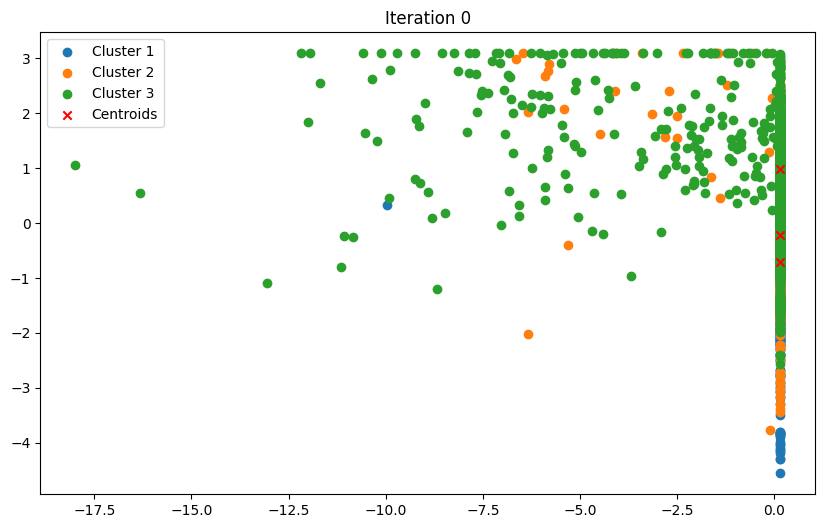

Iteration 0: Centroid shift = 3.3865
Cluster 0: Number of points = 1510
Shape of cluster_points: (1510, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3550
Shape of cluster_points: (3550, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 2135
Shape of cluster_points: (2135, 22)
Shape of clusters array: (7195,)
Iteration 1:
  Inertia: 23599.4427
  Silhouette Coefficient: 0.3169


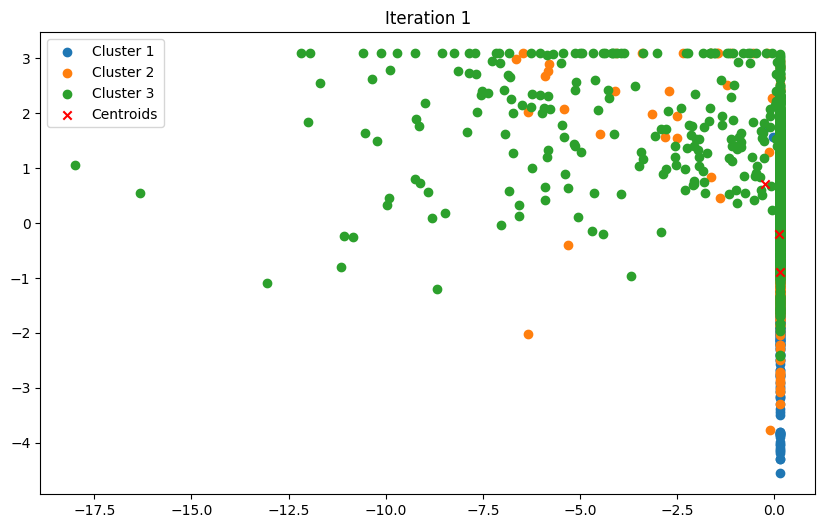

Iteration 1: Centroid shift = 0.8982
Cluster 0: Number of points = 1596
Shape of cluster_points: (1596, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3550
Shape of cluster_points: (3550, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 2049
Shape of cluster_points: (2049, 22)
Shape of clusters array: (7195,)
Iteration 2:
  Inertia: 23616.4803
  Silhouette Coefficient: 0.3188


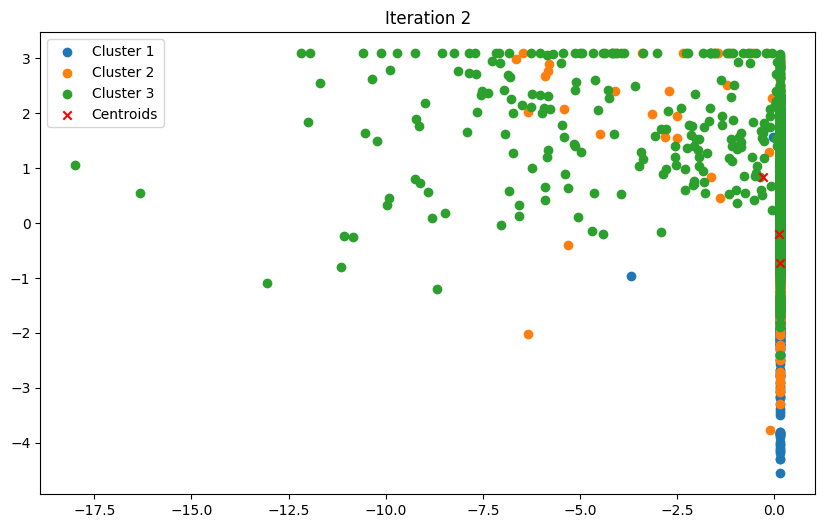

Iteration 2: Centroid shift = 0.1642
Cluster 0: Number of points = 1636
Shape of cluster_points: (1636, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3548
Shape of cluster_points: (3548, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 2011
Shape of cluster_points: (2011, 22)
Shape of clusters array: (7195,)
Iteration 3:
  Inertia: 23625.4369
  Silhouette Coefficient: 0.3189


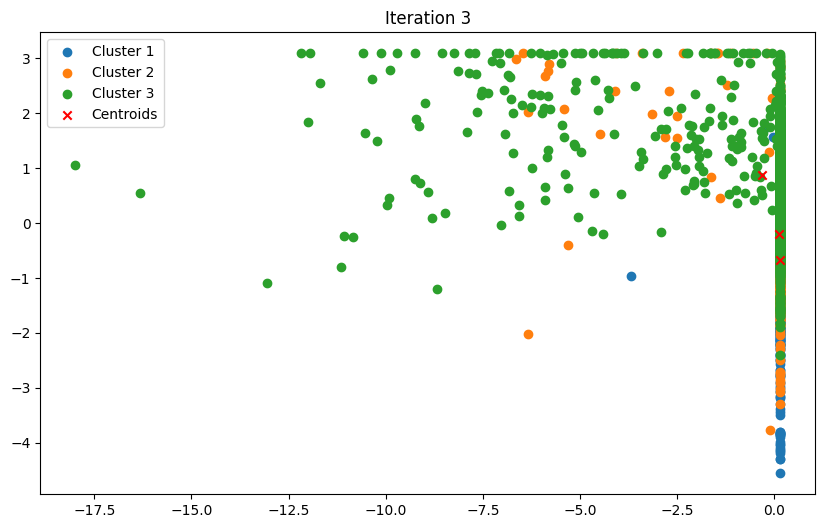

Iteration 3: Centroid shift = 0.0753
Cluster 0: Number of points = 1655
Shape of cluster_points: (1655, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3548
Shape of cluster_points: (3548, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 1992
Shape of cluster_points: (1992, 22)
Shape of clusters array: (7195,)
Iteration 4:
  Inertia: 23627.5397
  Silhouette Coefficient: 0.3189


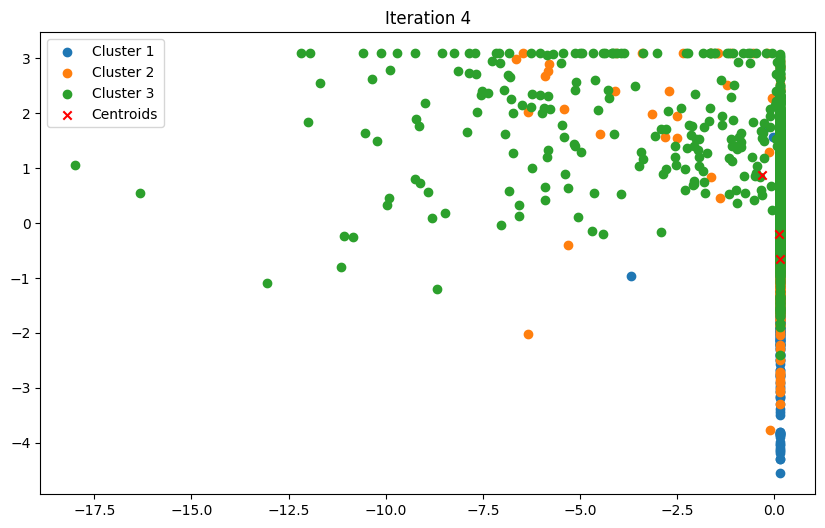

Iteration 4: Centroid shift = 0.0367
Cluster 0: Number of points = 1669
Shape of cluster_points: (1669, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3548
Shape of cluster_points: (3548, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 1978
Shape of cluster_points: (1978, 22)
Shape of clusters array: (7195,)
Iteration 5:
  Inertia: 23628.7627
  Silhouette Coefficient: 0.3193


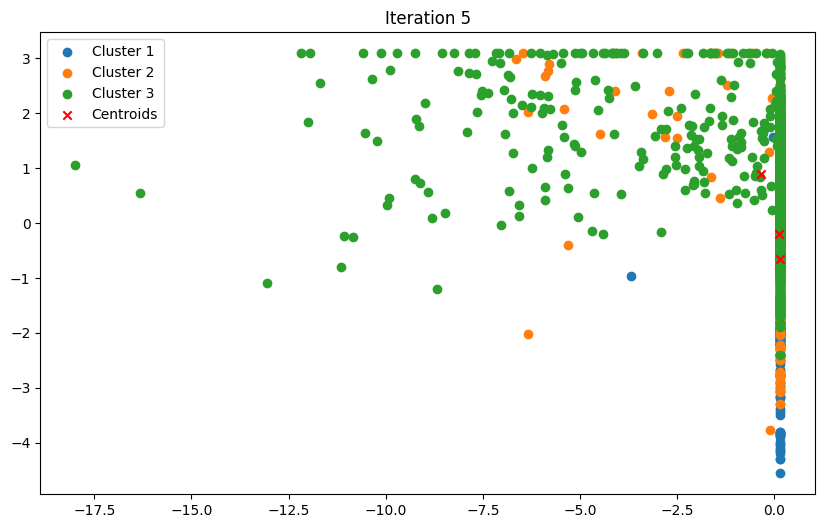

Iteration 5: Centroid shift = 0.0309
Cluster 0: Number of points = 1669
Shape of cluster_points: (1669, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3549
Shape of cluster_points: (3549, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 1977
Shape of cluster_points: (1977, 22)
Shape of clusters array: (7195,)
Iteration 6:
  Inertia: 23630.0342
  Silhouette Coefficient: 0.3192


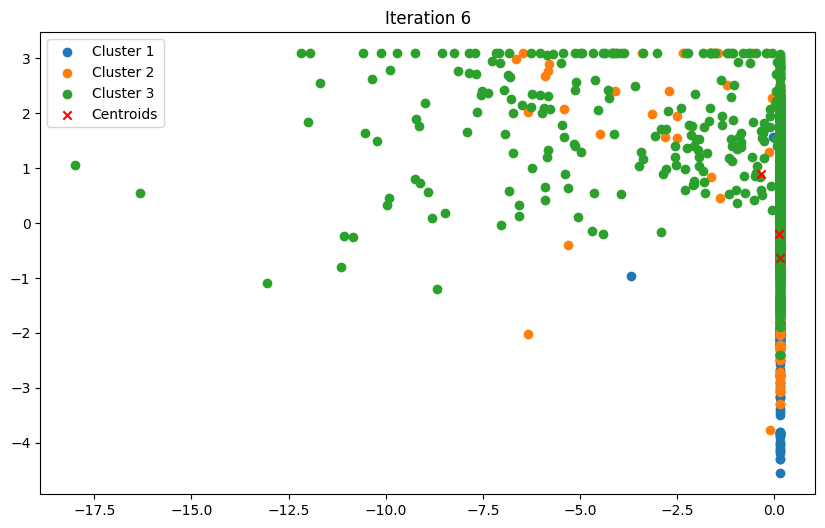

Iteration 6: Centroid shift = 0.0057
Cluster 0: Number of points = 1671
Shape of cluster_points: (1671, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3549
Shape of cluster_points: (3549, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 1975
Shape of cluster_points: (1975, 22)
Shape of clusters array: (7195,)
Iteration 7:
  Inertia: 23630.1361
  Silhouette Coefficient: 0.3192


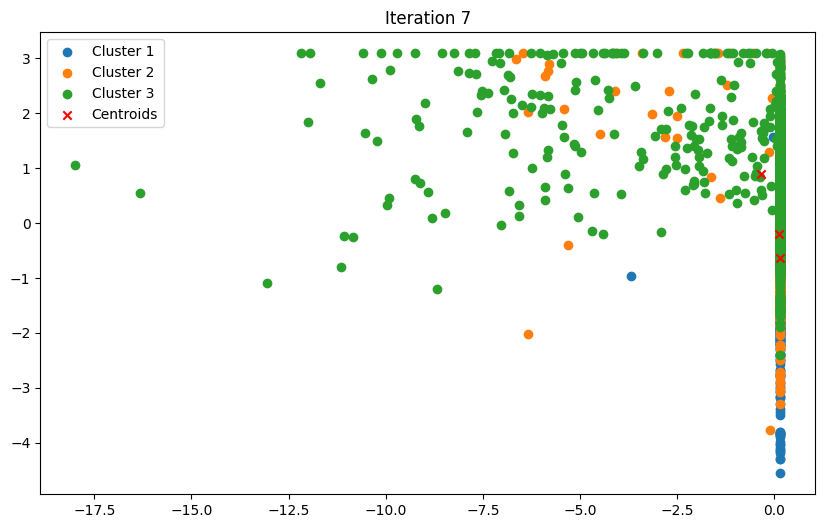

Iteration 7: Centroid shift = 0.0056
Cluster 0: Number of points = 1671
Shape of cluster_points: (1671, 22)
Shape of clusters array: (7195,)
Cluster 1: Number of points = 3549
Shape of cluster_points: (3549, 22)
Shape of clusters array: (7195,)
Cluster 2: Number of points = 1975
Shape of cluster_points: (1975, 22)
Shape of clusters array: (7195,)
Iteration 8:
  Inertia: 23630.4227
  Silhouette Coefficient: 0.3192


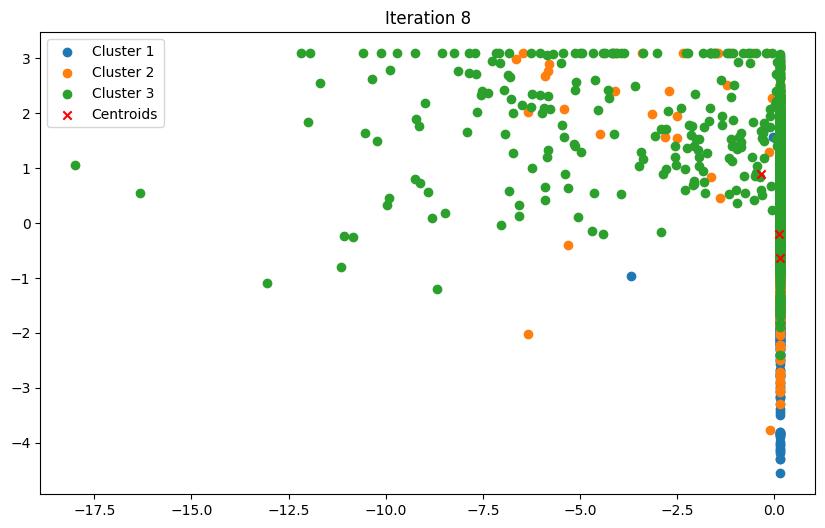

Iteration 8: Centroid shift = 0.0000
Convergence reached.


In [ ]:
# Run k-means clustering algorithm! (Set k first though!)
k = 3 # Number of clusters
centroids, clusters, inertia_values = k_means(
    X_scaled,
    k=k,
    max_iterations=100,
    tolerance=1e-4,
    init_method="kmeans++")

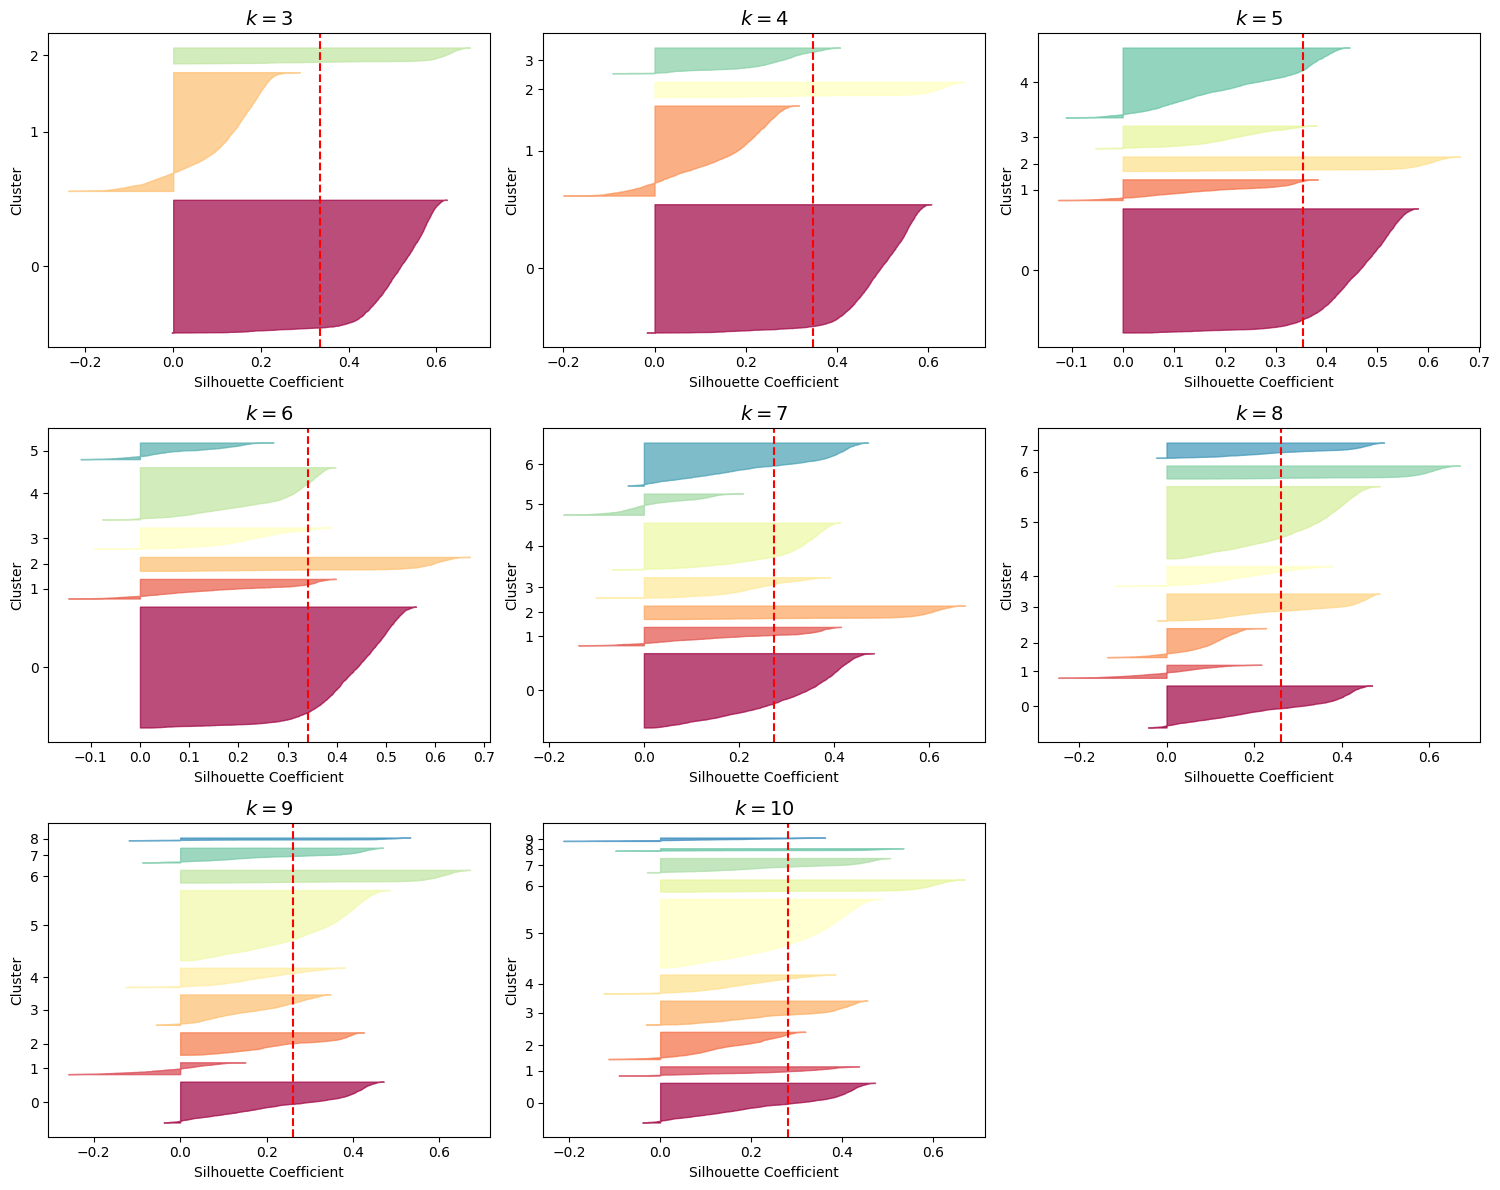

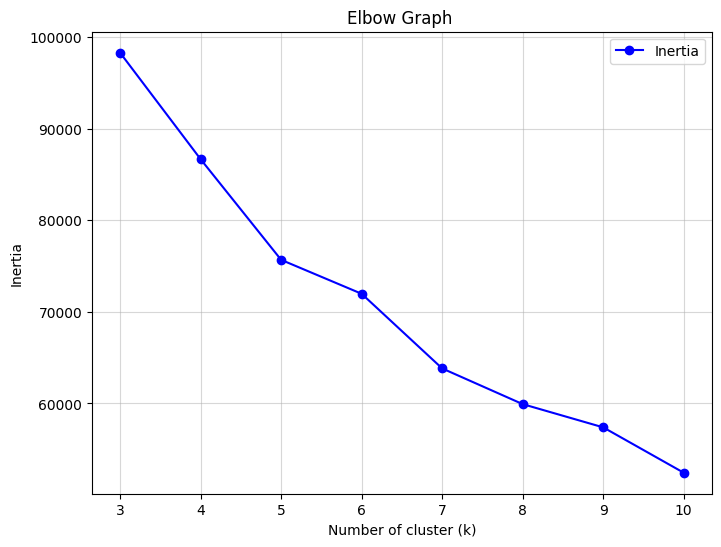

In [ ]:
#Silhouette Analysis Plotting
k_values = [3, 4, 5, 6, 7, 8, 9, 10]
kmeans_results = {}
inertia_values = [] #Inertia for elbow graph
for k in k_values:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42)
    kmeans.fit(X_scaled)
    kmeans_results[k] = kmeans
    inertia_values.append(kmeans.inertia_)

plot_silhouette_diagrams(X_scaled, kmeans_results, k_values)
plot_elbow_graph(inertia_values)

## Have a great day!